# Demonstration of OVRO-LWA Stage 3 M&C

## Python APIs
1. ARX (Larry, Rick)
2. F-engine (Jack)
3. X-engine (Jack)
4. Data capture (Jayce)

## Setup

Set up scripts often run on lxdlwacr. lxdlwagpu03 is also ok.

Jack recommends:
1. Program and initialize SNAPs with `lwa_snap_feng_init.py -e -s -m -i -p -o ~/proj/caltech-lwa/control_sw/config/lwa_corr_config.yaml snap01`. Adding `-t` will send test data.
2. Fire up the GPU pipelines with `lwa352-start-pipeline.sh` (possibly killing existing pipelines first)
3. Watch X-engine log files until things are running with names `<hostname>.<pipeline_id>.log`
4. Trigger correlator output with `lwa352_arm_correlator.py`
5. Currently, success means 10s integrations sent to lxdlwagpu03 for capture by Jayce's bifrost pipeline. Good logging:

`2021-07-08 20:33:17 [INFO    ] CORR OUTPUT >> Sending complete for time_tag 318652171392122880 in 2.12 seconds (381714432 Bytes; 1.44 Gb/s)`

Note: 
* See also video recording of demo.


## Breakdown
1. lwa352-stop-pipeline.sh # essentially just a `killall lwa352-pipeline.py`

## Set up

In [155]:
%matplotlib inline

In [156]:
from bokeh.layouts import column, row
from bokeh.models import ColumnDataSource, DataRange1d, Select
from bokeh.palettes import Blues4
from bokeh.plotting import figure
from bokeh.io import show, output_notebook
import pandas as pd

output_notebook()

Loading BokehJS ...

In [157]:
cd ~/ovro_data_recorder/


/home/ubuntu/ovro_data_recorder


In [158]:
import matplotlib.pyplot as plt
import numpy as np

from common import ETCD_HOST, ETCD_PORT  #  works in ovro_data_recorder directory

## etcd level M&C (low level)

In [159]:
import etcd3
le = etcd3.client(ETCD_HOST, ETCD_PORT)

# e.g., print a key:
# -- "le.get('/cmd/arx/2')"
# -- "le.get('/mon/snap/1')"

## ARX M&C

* Repo forthcoming "lwa-pyutils"
* This will be wrapped to refer to antenna, rather than ARX.
* Note that ARX come up with max attenuation (31.5)

In [160]:
from lwautils import lwa_arx
ma = lwa_arx.ARX()

/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/lwautils/conf/etcdConfig.yml


In [161]:
adrs = [17,21,27,31]  # currently installed
for adr in adrs:
    ma.raw(adr, 'SETSC387')
    
# use pre set #1?

In [162]:
ma.get_chan_cfg(adr, 0)

{'sig_on': True,
 'narrow_lpf': False,
 'narrow_hpf': False,
 'first_atten': 7.5,
 'second_atten': 15.0,
 'dc_on': True}

In [163]:
# setting custom config with dictionary

#ARX_CHAN_CFG = {}
#ARX_CHAN_CFG["dc_on"] = True
#ARX_CHAN_CFG["sig_on"] = True
#ARX_CHAN_CFG["narrow_lpf"] = False
#ARX_CHAN_CFG["narrow_hpf"] = False
#ARX_CHAN_CFG["first_atten"] = 7.5
#ARX_CHAN_CFG["second_atten"] = 15.0
#for adr in adrs:
#    ma.set_all_chan_cfg(adr, ARX_CHAN_CFG)  # this returns KeyError atm

## F-engine M&C

* Repo https://github.com/realtimeradio/caltech-lwa
* python install "control_sw"

In [164]:
from lwa_f import snap2_fengine
lwa_f = snap2_fengine.Snap2Fengine('snap01')

2021-08-16 21:08:06,655 - lwa_f.blocks.block:snap01 - INFO - adc - Detected FMC ADC board on port 0
2021-08-16 21:08:06,960 - lwa_f.blocks.block:snap01 - INFO - adc - Detected FMC ADC board on port 1


In [165]:
for block in sorted(lwa_f.blocks.keys()):
    print(block)

adc
autocorr
corr
delay
eq
eqtvg
eth
fpga
input
noise
packetizer
pfb
powermon
reorder
sync


In [168]:
lwa_f.eqtvg.tvg_is_enabled()

False

In [169]:
lwa_f.eqtvg.tvg_disable()

In [170]:
lwa_f.input.use_adc()

2021-08-16 21:08:12,851 - lwa_f.blocks.block:snap01 - INFO - Stream None: switching to ADC


In [171]:
st0, st1 = lwa_f.input.get_status()
pows = np.array([v for (k,v) in st0.items() if 'pow' in k])
means = np.array([v for (k,v) in st0.items() if 'mean' in k])

In [172]:
TOOLTIPS = [("SNAP2 input", "$index")]
plot = figure(plot_width=950, plot_height=500, title='F stats', tools='hover,wheel_zoom,reset',
              tooltips=TOOLTIPS)
plot.xaxis.axis_label = 'Powers'
plot.yaxis.axis_label = 'Means'
_ = plot.scatter(x=pows, y=means)
show(plot)

2021-08-16 21:08:20,868 - lwa_f.blocks.block:snap01 - INFO - input - Getting histogram for stream 24


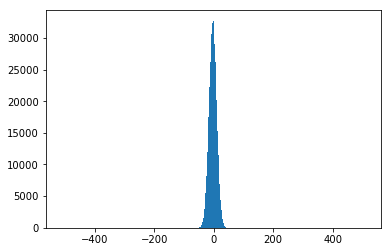

In [173]:
hist = lwa_f.input.plot_histogram(24)

In [174]:
specs = lwa_f.autocorr.get_new_spectra()   # before 4-bit scaling/quantization

In [175]:
len(specs), len(specs[0])

(16, 4096)

In [176]:
autospecs = []
for i in range(64):
    spec = lwa_f.corr.get_new_corr(i, i).real  # 8-channel average, normalized by accumulated time/chans
    autospecs.append(spec)

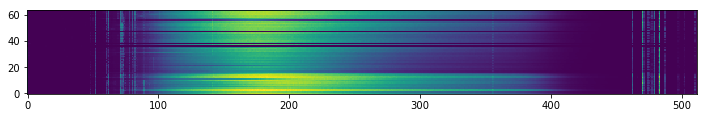

In [177]:
fig, (ax0) = plt.subplots(1, 1, figsize=(12,12))
#for autospec in autospecs:
ax0.imshow(np.vstack(autospecs), origin='bottom')

In [73]:
#np.savez('spec_auto_4.npz', autospec)

In [178]:
#dd = {'x': list(range(512))}
#
#for i in range(64):
#    dd[str(i)] = autospecs[i]
#
#source = ColumnDataSource(dd)

In [179]:
TOOLTIPS = [
#    ("Frequency channel", "$index"),
#    ("Autocorrelation value", "$y"),
    ("SNAP2 autocorr", "$name"),
]

plot = figure(plot_width=950, plot_height=500, title='autocorr spectra', tooltips=TOOLTIPS, tools='hover,wheel_zoom,reset')
plot.xaxis.axis_label = 'Channel'
plot.yaxis.axis_label = 'Power'
for i in range(64):
    _ = plot.line(x=list(range(512)), y=autospecs[i], color='grey', name=str(i), hover_color='firebrick')
show(plot)

## X-engine M&C

* Repo https://github.com/realtimeradio/caltech-lwa
* python install "control_sw"

"/mon/corr/xeng/<hostname>/pipeline/<pid>/corr" or "beamform"

In [180]:
from lwa352_pipeline_control import Lwa352PipelineControl
lwa_x = Lwa352PipelineControl(pipeline_id=0, etcdhost='10.42.0.64', host='lxdlwagpu02')

In [181]:
lwa_x.corr.get_bifrost_status()

{'pid': 13753,
 'name': 'Corr',
 'cmd': '/home/ubuntu/anaconda3/bin/python /home/ubuntu/anaconda3/bin/lwa352-pipeline.py --nobeamform --ibverbs --gpu 0 --pipelineid 0 --useetcd --etcdhost etcdv3service.sas.pvt --ip 10.41.0.33 --bufgbytes 4 --cores 1,2,3,4,5,6,7,7,7,7,7,7,7 --logfile /home/ubuntu/lxdlwagpu02.0.log ',
 'core': 5,
 'acquire': 0.0,
 'process': 0.0,
 'reserve': 0.0,
 'total': 0.0,
 'gbps': 0.0,
 'time': 1628692485.605856,
 'stats': {'xgpu_acc_len': 480, 'state': 'starting'}}

In [182]:
lwa_x.corr_acc.get_bifrost_status()

{'pid': 13753,
 'name': 'CorrAcc',
 'cmd': '/home/ubuntu/anaconda3/bin/python /home/ubuntu/anaconda3/bin/lwa352-pipeline.py --nobeamform --ibverbs --gpu 0 --pipelineid 0 --useetcd --etcdhost etcdv3service.sas.pvt --ip 10.41.0.33 --bufgbytes 4 --cores 1,2,3,4,5,6,7,7,7,7,7,7,7 --logfile /home/ubuntu/lxdlwagpu02.0.log ',
 'core': 6,
 'acquire': 0.0,
 'process': 0.0,
 'reserve': 0.0,
 'total': 0.0,
 'gbps': 0.0,
 'time': 1628692485.6058536,
 'stats': {'state': 'starting'}}

In [183]:
from astropy import time
time.Time.now().unix

1629148167.533845

## Data capture M&C

In [186]:
# gpu03 runs capture server
import mcs #  works in ovro_data_recorder directory
from common import LWATime #  works in ovro_data_recorder directory

from datetime import timedelta, datetime

c = mcs.Client()
mcs_id = 'drvs19'   # data recorder visibilities slow server 19 (end of x-engine IP address)

Exception in thread etcd3_watch_7f0521191710:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/casa/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/anaconda3/envs/casa/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/etcd3/watch.py", line 126, in _run
    metadata=self._metadata)
  File "/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/grpc/_channel.py", line 1209, in __call__
    operationses, event_handler, self._context)
  File "/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/grpc/_channel.py", line 1303, in create
    operationses_and_tags, context)
  File "src/python/grpcio/grpc/_cython/_cygrpc/channel.pyx.pxi", line 476, in grpc._cython.cygrpc.Channel.integrated_call
  File "src/python/grpcio/grpc/_cython/_cygrpc/channel.pyx.pxi", line 294, in grpc._cython.cygrpc._integrated_ca

In [185]:
# start
t_now = LWATime(datetime.utcnow() + timedelta(seconds=15), format='datetime', scale='utc')
mjd_now = int(t_now.mjd)
mpm_now = int((t_now.mjd - mjd_now)*86400.0*1000.0)
r = c.send_command(mcs_id, 'start', start_mjd=mjd_now, start_mpm=mpm_now)

ERROR1: timeout


In [27]:
# stop
r = c.send_command(mcs_id, 'stop', stop_mjd='now', stop_mpm=0)

In [124]:
print(le.get(f'/mon/{mcs_id}/bifrost/rx_rate'), le.get(f'/mon/{mcs_id}/bifrost/max_process'))

(b'{"timestamp": 1626817458.744882, "value": 37777422.795293726, "unit": "B/s"}', <etcd3.client.KVMetadata object at 0x7f04f21ed0f0>) (b'{"timestamp": 1626817458.7288575, "value": 9.93939, "unit": "s"}', <etcd3.client.KVMetadata object at 0x7f052127aef0>)


In [125]:
le.get(f'/mon/{mcs_id}/statistics/avg')

(b'{"timestamp": 1626817411.3144164, "value": [[98487.625, 199660.48958333334, 60594.307291666664, 72572.55729166667, 86389.14583333333, 45652.067708333336, 177595.15625, 74156.171875, 27978.135416666668, 34378.447916666664, 14824.427083333334, 36176.229166666664, 40714.645833333336, 46347.296875, 54509.036458333336, 48664.833333333336, 63346.0625, 52542.34375, 73311.640625, 66393.08333333333, 77588.44791666667, 69675.36979166667, 67789.890625, 44.817708333333336, 90773.72916666667, 465.5677083333333, 108691.86458333333, 95405.75520833333, 59996.4375, 103383.38020833333, 122105.72395833333, 31409.973958333332, 107129.97395833333, 225832.265625, 93287.41666666667, 99095.34375, 125124.78645833333, 73617.609375, 196630.90104166666, 161082.05208333334, 61800.442708333336, 48789.786458333336, 47868.90625, 61837.15625, 56140.484375, 62600.078125, 87927.4375, 68980.80208333333, 76358.796875, 98293.34375, 122365.67708333333, 71434.72395833333, 101571.06770833333, 74956.54166666667, 140709.5208